In [2]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import joblib


import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression



from utils.load_data import load_data_train, load_data_test, load_data_val
from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,recall_score,balanced_accuracy_score,classification_report,ConfusionMatrixDisplay

from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import shap
from sklearn.model_selection import train_test_split

In [3]:
X_train,y_train = load_data_train()

In [4]:
X_test,y_test =load_data_test()

In [5]:
X_val,y_val = load_data_val()

In [6]:
import numpy as np

def balanced_subset(data, target, subset_size):
    unique_labels, counts = np.unique(target, return_counts=True)
    min_count = min(counts)
    subset_size = min(min_count * len(unique_labels), subset_size)
    
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    target = target[indices]
    
    data_subset = []
    target_subset = []
    for label in unique_labels:
        label_indices = np.where(target == label)[0]
        label_indices = label_indices[:subset_size // len(unique_labels)]
        data_label = data[label_indices]
        target_label = target[label_indices]
        data_subset.append(data_label)
        target_subset.append(target_label)
    
    data_subset = np.concatenate(data_subset)
    target_subset = np.concatenate(target_subset)
    
    return data_subset,target_subset,unique_labels


In [7]:
import numpy as np


def data_centered_ensemble(X, y, subsets, subset_size):
    
    models= []
    contributions = []
    # Split the training data into several subsets
    for i in range(subsets):
        X_train,y_train, _ = balanced_subset(X, y, subset_size)
        

        models_folder = "trained_models"
        subset_folder = f"{models_folder}/subset_{i}"
        # get the list of models in the subset folder
        model_files = [f for f in os.listdir(subset_folder) if f.endswith('.joblib')]

        loaded_models = [joblib.load(f"{subset_folder}/{f}") for f in model_files]
        models.extend(loaded_models)
        predictions_list= []
        for model in loaded_models:
        
            predictions_list.append(model.predict(X_test))
           
            predictions = np.array(predictions_list)
            final_predictions = np.zeros_like(y_test)
           

        for i in range(predictions.shape[1]):
            prediction_counts = np.bincount(predictions[:,i].astype(int))
            final_prediction = np.argmax(prediction_counts)
            final_predictions[i] = final_prediction
            
        # Calculate the accuracy of the ensemble on the test data
        accuracy = np.sum(final_predictions == y_test) / y_test.shape[0]
        
        return accuracy, final_predictions, loaded_models






In [8]:
accuracy,final_predictions,loaded_models = data_centered_ensemble(X_train, y_train, subsets=5, subset_size=1032471)

In [9]:
models=[]
for i in range(5):
    models_folder = "trained_models"
    subset_folder = f"{models_folder}/subset_{i}"
    # get the list of models in the subset folder
    model_files = [f for f in os.listdir(subset_folder) if f.endswith('.joblib')]

    loaded_models = [joblib.load(f"{subset_folder}/{f}") for f in model_files]
    models.extend(loaded_models)

In [63]:

# Get the predictions of each model on the validation set
prediction_probs = np.array([model.predict_proba(X_val) for model in loaded_models])
 

In [64]:
prediction_probs.shape

(9, 3905726, 2)

In [65]:
class_probs = np.mean(prediction_probs, axis=1)

In [70]:
class_probs

array([[0.50963833, 0.49036167],
       [0.6636396 , 0.3363604 ],
       [0.71925787, 0.28074213],
       [0.32654723, 0.67345277],
       [0.66467291, 0.33532709],
       [0.68680928, 0.31319072],
       [0.70614445, 0.29385555],
       [0.74544405, 0.25455595],
       [0.69357943, 0.30642056]])

In [66]:
# compute weights from class probabilities
weights = 1.0 / class_probs

# normalize weights so they sum to 1
weights /= np.sum(weights)

In [67]:
weights

array([[0.04681787, 0.04865833],
       [0.03595352, 0.07093635],
       [0.03317333, 0.08498967],
       [0.07306808, 0.03542963],
       [0.03589763, 0.07115494],
       [0.03474062, 0.07618419],
       [0.03378938, 0.08119697],
       [0.03200801, 0.09373256],
       [0.03440151, 0.07786742]])

In [68]:
weights.shape

(9, 2)

In [48]:
plt.bar(np.arange(len(weights[:,0])),weights[:,0])

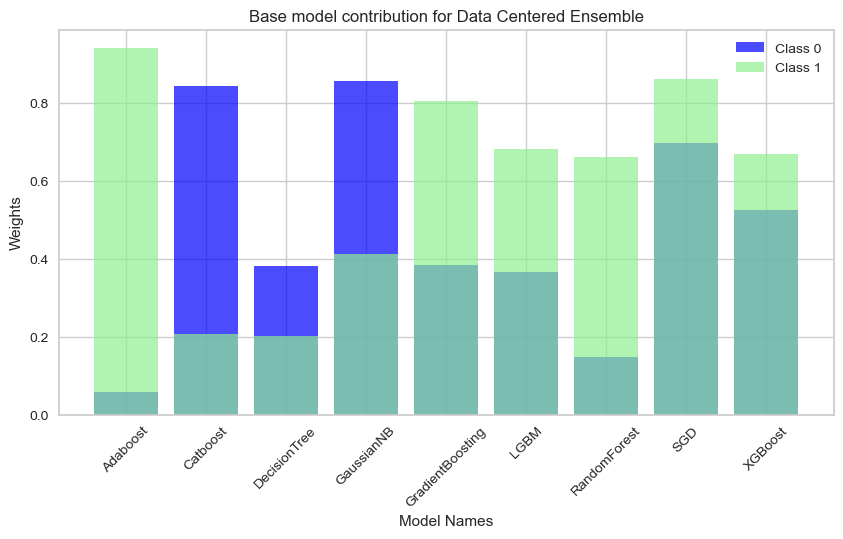

In [94]:
import matplotlib.pyplot as plt

# Assuming weights is a numpy array with shape (N, 2)
weights = np.random.rand(9, 2)

# Set up the x-axis labels
x_labels = ['Adaboost', 'Catboost', 'DecisionTree', 'GaussianNB', 'GradientBoosting',
            'LGBM', 'RandomForest', 'SGD', 'XGBoost']

# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(10, 5))

# Define the colors for each class
colors = ['blue', 'lightgreen']

# Loop over the classes
for i in range(2):
    # Extract the weights for the current class
    y = weights[:, i]
    # Plot the bar plot for the current class with the corresponding color
    x_labels_with_class = [f"{label}" for label in x_labels]

    ax.bar(x_labels_with_class, y, color=colors[i], alpha=0.7)


# Set axis labels and title
ax.set_ylabel('Weights')
ax.set_xlabel('Model Names')
ax.set_title('Base model contribution for Data Centered Ensemble')

# Rotate the x-axis labels
ax.tick_params(axis='x', rotation=45)
ax.legend(['Class 0', 'Class 1'])

# Show the plot
plt.show()


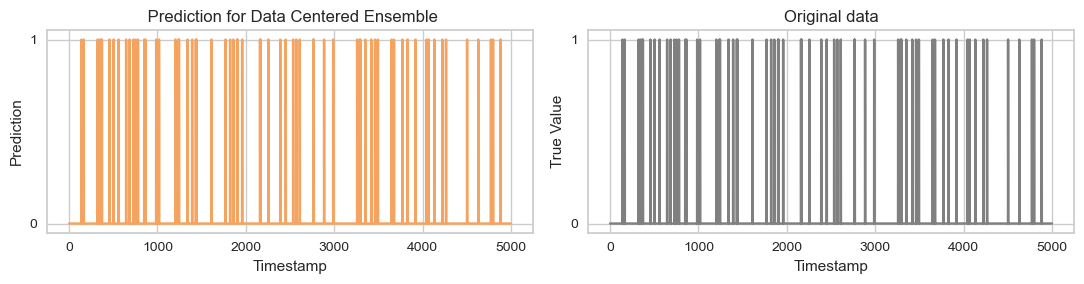

<Figure size 1200x300 with 0 Axes>

In [91]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = (12,3)

# First plot
plt.subplot(1,2,1)
plt.title(" Prediction for Data Centered Ensemble")
plt.plot(np.arange(len(final_predictions[23000:28000])),final_predictions[23000:28000],color="sandybrown")
plt.xlabel("Timestamp")
plt.ylabel("Prediction")
plt.yticks([0.0, 1.0])

# Second plot
plt.subplot(1,2,2)
plt.title("Original data")
plt.plot(np.arange(len(y_test[23000:28000])),y_test[23000:28000],color="grey")
plt.xlabel("Timestamp")
plt.ylabel("True Value")
plt.yticks([0.0, 1.0])

plt.tight_layout()
plt.show()
plt.savefig('Data_centered_ensemble.png')

87.0


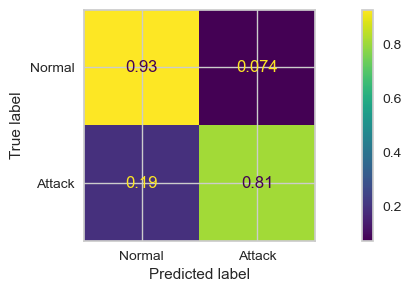

In [92]:
model_cm =confusion_matrix(y_test, final_predictions,normalize='true')
# print(round(accuracy_score(y_test, final_predictions),2)*100)
y_acc = accuracy_score(y_test, final_predictions)
y_f1score = f1_score(y_test, final_predictions)
y_recall = recall_score(y_test, final_predictions)
y_bal = balanced_accuracy_score(y_test, final_predictions)
print(round(balanced_accuracy_score(y_test, final_predictions),2)*100)

disp = ConfusionMatrixDisplay(confusion_matrix=model_cm, display_labels = ["Normal","Attack"])
disp.plot()
# plt.savefig(f'{type(model).__name__}.png')

In [93]:
print(classification_report(y_test, final_predictions))

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94   1560065
         1.0       0.72      0.81      0.76    363663

    accuracy                           0.90   1923728
   macro avg       0.84      0.87      0.85   1923728
weighted avg       0.91      0.90      0.91   1923728

